In [1]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings
import os
from pathlib import Path
from pydub import AudioSegment

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/3533495058.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [5]:
import os
from pathlib import Path
import pandas as pd

# Define dataset path
dataset_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/")
train_path = dataset_path / "train_5sec"

# Function to traverse directories and map file information to labels
def traverse_and_map(directory, label):
    audio_files = []
    labels = []
    start_times = []
    end_times = []
    
    if not directory.exists():
        print(f"Directory does not exist: {directory}")
        return pd.DataFrame()  # Return empty DataFrame if directory doesn't exist
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                # Prepend full dataset path to the file path
                audio_path = dataset_path / Path(root).relative_to(dataset_path) / file
                audio_files.append(str(audio_path))
                labels.append(label)
                start_times.append(0.0)  # Fixed start time
                end_times.append(5.0)   # Fixed end time

    # Create DataFrame for the current directory
    data = {
        "file": audio_files,
        "start_time": start_times,
        "end_time": end_times,
        "A": labels
    }
    return pd.DataFrame(data)

# Initialize a dictionary to hold DataFrames for each training size
labels_trains = {}

# Iterate over each train size folder
if train_path.exists():
    for train_size_dir in train_path.iterdir():
        if train_size_dir.is_dir():  # Ensure it's a directory
            training_size = train_size_dir.name  # Get the name of the training size directory

            # Process `pos` and `neg` subdirectories
            pos_dir = train_size_dir / "pos"
            neg_dir = train_size_dir / "neg"
            df_pos = traverse_and_map(pos_dir, 1)  # 1 for "pos" files
            df_neg = traverse_and_map(neg_dir, 0)  # 0 for "negative" files

            # Combine the DataFrames for `pos` and `neg`
            combined_df = pd.concat([df_pos, df_neg], ignore_index=True)

            # Set MultiIndex with 'file', 'start_time', and 'end_time'
            combined_df.set_index(["file", "start_time", "end_time"], inplace=True)

            # Rename the only column to "A"
            combined_df.columns = ['A']

            # Store the DataFrame in the dictionary
            labels_trains[training_size] = combined_df

            # Optionally, save each DataFrame to a CSV file
            output_path = dataset_path / f"labels_trains_{training_size}.csv"
            combined_df.to_csv(output_path)
            print(f"DataFrame saved for training size {training_size}: {output_path}")
else:
    print(f"Train path does not exist: {train_path}")

# Display the DataFrames for verification
for training_size, df in labels_trains.items():
    print(f"\nDataFrame for training size {training_size}:")
    print(df.head())


DataFrame saved for training size train_size_150: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/labels_trains_train_size_150.csv
DataFrame saved for training size train_size_25: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/labels_trains_train_size_25.csv
DataFrame saved for training size train_size_300: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/labels_trains_train_size_300.csv
DataFrame saved for training size train_size_275: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/labels_trains_train_size_275.csv
DataFrame saved for training size train_size_250: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/labels_trains_train_size_250.csv
DataFrame saved for training size train_size_175: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/labels_trains_train_size_175.csv
DataFrame saved for trai

Processing data for training set

In [6]:
labels_trains['train_size_150'].head(20)

,,,A
file,start_time,end_time,
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/train_5sec/train_size_150/pos/t-11105570_94_9sec.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/train_5sec/train_size_150/pos/t-11105570_108_9sec.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/train_5sec/train_size_150/pos/t-11105570_732_9sec.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/train_5sec/train_size_150/pos/t-11105570_555_9sec.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/train_5sec/train_size_150/pos/t-11105570_266_9sec.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/train_5sec/train_size_150/pos/t-11105570_140_9sec.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/train_5sec/train_size_150/pos/t-11105570_326_9sec.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/train_5sec/train_size_150/pos/t-11105570_673_9sec.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/train_5sec/train_size_150/pos/t-11105570_414_9sec.wav,0.0,5.0,1


Prepare audio Data

Step 1: Train shallow classifier on Perch embeddings

In [7]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


Step 2: Generate embeddings on the training and validation data

Training size 25

In [8]:
emb_train_25 = model.embed(labels_trains['train_size_25'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999979166666667 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999395833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.9995625 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999458333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: Use

In [12]:
csv_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/test_5sec/test_dataset_5sec.csv")
audio_file_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/test_5sec/test_dataset_5sec.wav")
output_folder = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/test_5sec/clips")
output_csv_dir = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/test_5sec/")
output_csv = output_csv_dir / "processed_test_dataset_5sec.csv"

# Ensure the output directories exist
output_folder.mkdir(parents=True, exist_ok=True)
output_csv_dir.mkdir(parents=True, exist_ok=True)

# Read the CSV file
df_csv = pd.read_csv(csv_path)

# Determine label based on conditions
df_csv["A"] = df_csv.apply(
    lambda row: 1 if row["label"] == 1 and row["Annotation"] == "WT" else 0, axis=1
)

# Load the audio file
audio = AudioSegment.from_file(audio_file_path)

# Initialize lists for DataFrame creation
file_paths = []
start_times = []
end_times = []
labels = []

# Partition the audio file into 5-second clips based on CSV
for index, row in df_csv.iterrows():
    start_time = index * 5 * 1000  # in milliseconds
    end_time = start_time + 5 * 1000  # 5 seconds later

    # Extract clip
    clip = audio[start_time:end_time]

    # Save clip to the output folder
    #WT does not have unique row identifier filename column
    filename = row["sample_id"]
    clip_path = output_folder / filename
    clip.export(clip_path, format="wav")

    # Add details to lists
    file_paths.append(str(clip_path))
    start_times.append(0.0)  
    end_times.append(5.0)  
    labels.append(row["A"])

# Create the DataFrame
df_processed = pd.DataFrame({
    "file": file_paths,
    "start_time": start_times,
    "end_time": end_times,
    "A": labels
})
df_processed.set_index(["file", "start_time", "end_time"], inplace=True)
df_processed.columns = ['A']
# Save the DataFrame to a CSV file
df_processed.to_csv(output_csv, index=False)

print(f"Processed dataset saved to {output_csv}")
print(f"Audio clips saved to {output_folder}")
print(df_processed.head())

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/3967381140.py:20: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/test_5sec/test_dataset_5sec.wav'>
  audio = AudioSegment.from_file(audio_file_path)
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/3967381140.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/test_5sec/clips/t-11105570_75_9sec.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/3967381140.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/test_5sec/clips/t-11105570_618_9sec.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/3967381140.py:40: ResourceWarning:

Processed dataset saved to /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/test_5sec/processed_test_dataset_5sec.csv
Audio clips saved to /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/woodhouses_toad_5sec/test_5sec/clips
                                                                        A
file                                               start_time end_time   
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0


In [13]:
labels_val = df_processed

In [14]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.984 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [15]:
emb_train_25 = torch.tensor(emb_train_25, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_25.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_25 = emb_train_25.view(emb_train_25.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_25: {emb_train_25.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

Original shape of emb_train: torch.Size([50, 512])
Reshaped emb_train_25: torch.Size([50, 1, 32, 16])
Reshaped emb_val: torch.Size([150, 1, 32, 16])


In [16]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [17]:
emb_train_25 = emb_train_25.repeat(1, 3, 1, 1)  # Duplicate to 3 channels
emb_val = emb_val.repeat(1, 3, 1, 1)

In [18]:
import torch.nn as nn

model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [19]:
quick_fit(model.network, emb_train_25, labels_trains['train_size_25'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 9.316764590039384e-06, Val Loss: 0.1443825513124466
val AU ROC: 0.997
val MAP: 0.997
Epoch 200/1000, Loss: 7.0729174694861285e-06, Val Loss: 0.14478318393230438
val AU ROC: 0.997
val MAP: 0.997
Epoch 300/1000, Loss: 5.8338882809039205e-06, Val Loss: 0.14947721362113953
val AU ROC: 0.996
val MAP: 0.996
Epoch 400/1000, Loss: 5.022705863666488e-06, Val Loss: 0.1530884951353073
val AU ROC: 0.996
val MAP: 0.996
Epoch 500/1000, Loss: 4.5910624066891614e-06, Val Loss: 0.1527101695537567
val AU ROC: 0.995
val MAP: 0.995
Epoch 600/1000, Loss: 4.090530637768097e-06, Val Loss: 0.14971809089183807
val AU ROC: 0.995
val MAP: 0.995
Epoch 700/1000, Loss: 3.7744930523331277e-06, Val Loss: 0.148784339427948
val AU ROC: 0.995
val MAP: 0.995
Epoch 800/1000, Loss: 3.631103254519985e-06, Val Loss: 0.1513211876153946
val AU ROC: 0.995
val MAP: 0.995
Epoch 900/1000, Loss: 3.2595964967185864e-06, Val Loss: 0.15838566422462463
val AU ROC: 0.995
val MAP: 0.995
Epoch 1000/1000, Loss: 2.9180

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/1842857064.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


0.9921777777777778

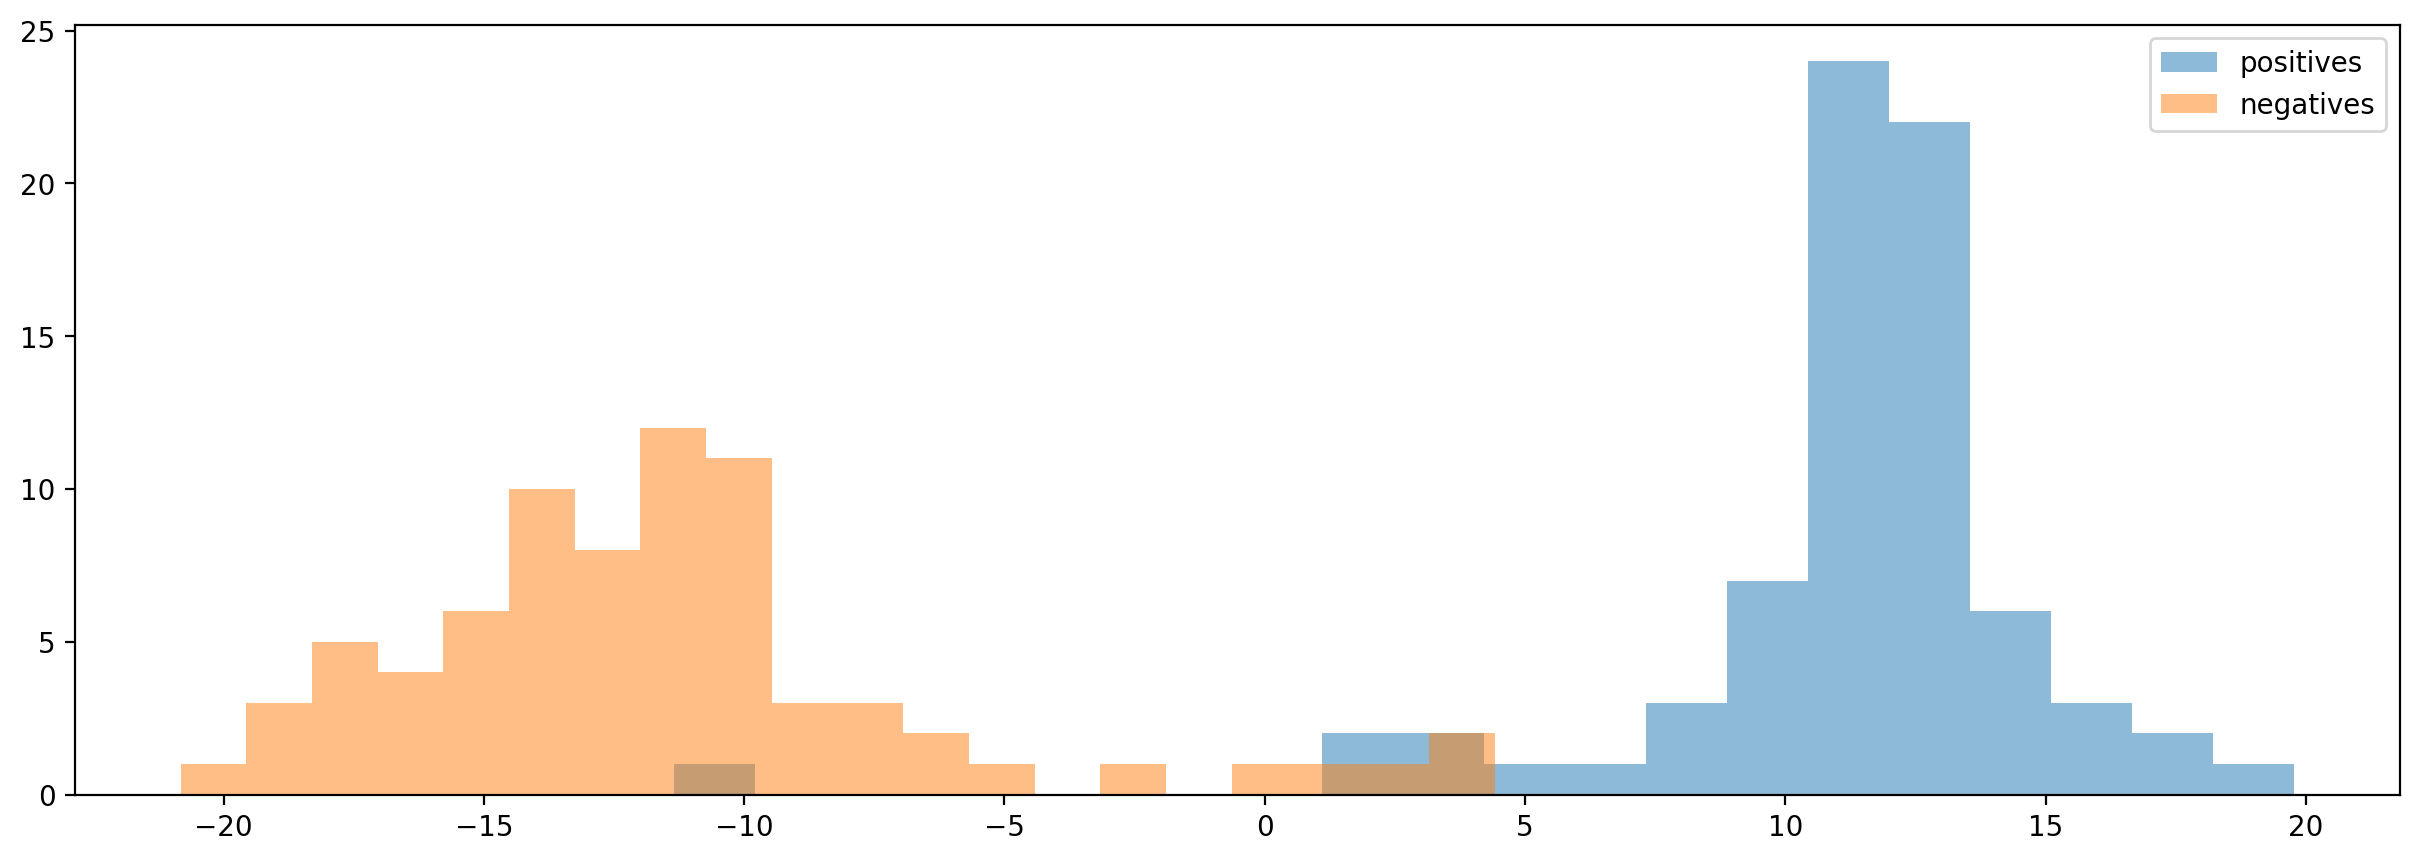

In [20]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_25 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_25

Training size 50

In [22]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [23]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.984 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [24]:
emb_train_50 = model.embed(labels_trains['train_size_50'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999979166666667 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999395833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.9995625 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.9994375 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning

In [25]:
emb_train_50 = torch.tensor(emb_train_50, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_50.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_50 = emb_train_50.view(emb_train_50.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_50: {emb_train_50.shape}")

Original shape of emb_train: torch.Size([100, 512])
Reshaped emb_train_50: torch.Size([100, 1, 32, 16])


In [26]:
emb_train_50 = emb_train_50.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [27]:
import torch.nn as nn

model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [28]:
quick_fit(model.network, emb_train_50, labels_trains['train_size_50'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 2.5742636353243142e-05, Val Loss: 0.09289776533842087
val AU ROC: 0.999
val MAP: 0.999
Epoch 200/1000, Loss: 1.7746948287822306e-05, Val Loss: 0.09889249503612518
val AU ROC: 0.999
val MAP: 0.999
Epoch 300/1000, Loss: 1.3723129086429253e-05, Val Loss: 0.10146433860063553
val AU ROC: 0.999
val MAP: 0.999
Epoch 400/1000, Loss: 1.1154035746585578e-05, Val Loss: 0.1040022149682045
val AU ROC: 0.999
val MAP: 0.999
Epoch 500/1000, Loss: 9.074219633475877e-06, Val Loss: 0.10584844648838043
val AU ROC: 0.999
val MAP: 0.999
Epoch 600/1000, Loss: 7.489143172279e-06, Val Loss: 0.10780443996191025
val AU ROC: 0.999
val MAP: 0.999
Epoch 700/1000, Loss: 6.341243988572387e-06, Val Loss: 0.10785360634326935
val AU ROC: 0.999
val MAP: 0.999
Epoch 800/1000, Loss: 5.46264709555544e-06, Val Loss: 0.1080387607216835
val AU ROC: 0.999
val MAP: 0.999
Epoch 900/1000, Loss: 4.295480721339118e-06, Val Loss: 0.11506899446249008
val AU ROC: 0.999
val MAP: 0.999
Epoch 1000/1000, Loss: 3.55912

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/2687331274.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.9994666666666667

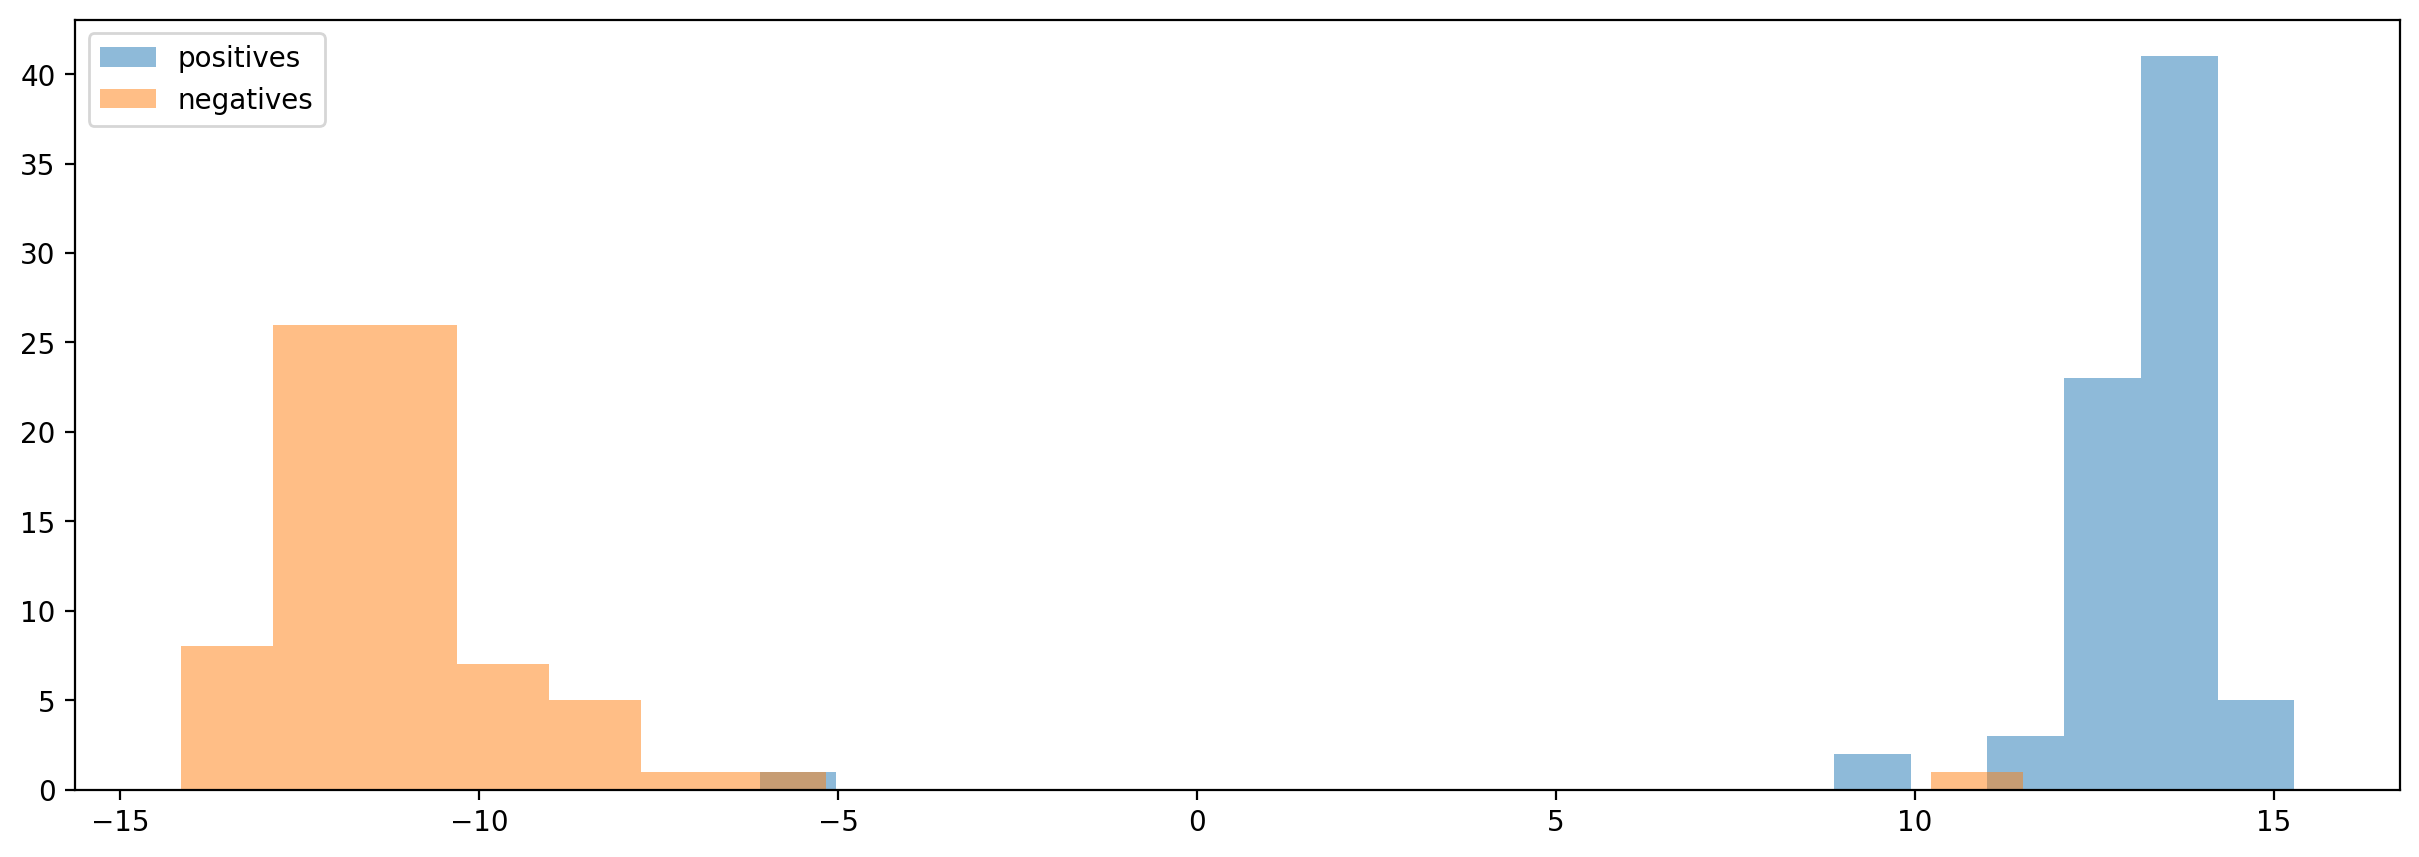

In [29]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_50 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_50

Training size 75

In [45]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [46]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.984 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [47]:
emb_train_75 = model.embed(labels_trains['train_size_75'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999979166666667 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999395833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.9994375 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999770833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: Use

In [48]:
emb_train_75 = torch.tensor(emb_train_75, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_75.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_75 = emb_train_75.view(emb_train_75.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_75: {emb_train_75.shape}")

Original shape of emb_train: torch.Size([150, 512])
Reshaped emb_train_75: torch.Size([150, 1, 32, 16])


In [49]:
emb_train_75 = emb_train_75.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [50]:
import torch.nn as nn

model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [51]:
quick_fit(model.network, emb_train_75, labels_trains['train_size_75'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 1.7089319953811355e-05, Val Loss: 0.029396165162324905
val AU ROC: 1.000
val MAP: 1.000
Epoch 200/1000, Loss: 1.1142374205519445e-05, Val Loss: 0.020341236144304276
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 8.378607162740082e-06, Val Loss: 0.012179023586213589
val AU ROC: 1.000
val MAP: 1.000
Epoch 400/1000, Loss: 6.6063057602150366e-06, Val Loss: 0.008832897059619427
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 5.379587946663378e-06, Val Loss: 0.006673228926956654
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 4.515423825068865e-06, Val Loss: 0.005183942150324583
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 3.778350446737022e-06, Val Loss: 0.004122318234294653
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 3.236018756069825e-06, Val Loss: 0.003420470980927348
val AU ROC: 1.000
val MAP: 1.000
Epoch 900/1000, Loss: 2.753042736003408e-06, Val Loss: 0.002908890601247549
val AU ROC: 1.000
val MAP: 1.000
Epoch 1000/1000,

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/3191350587.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


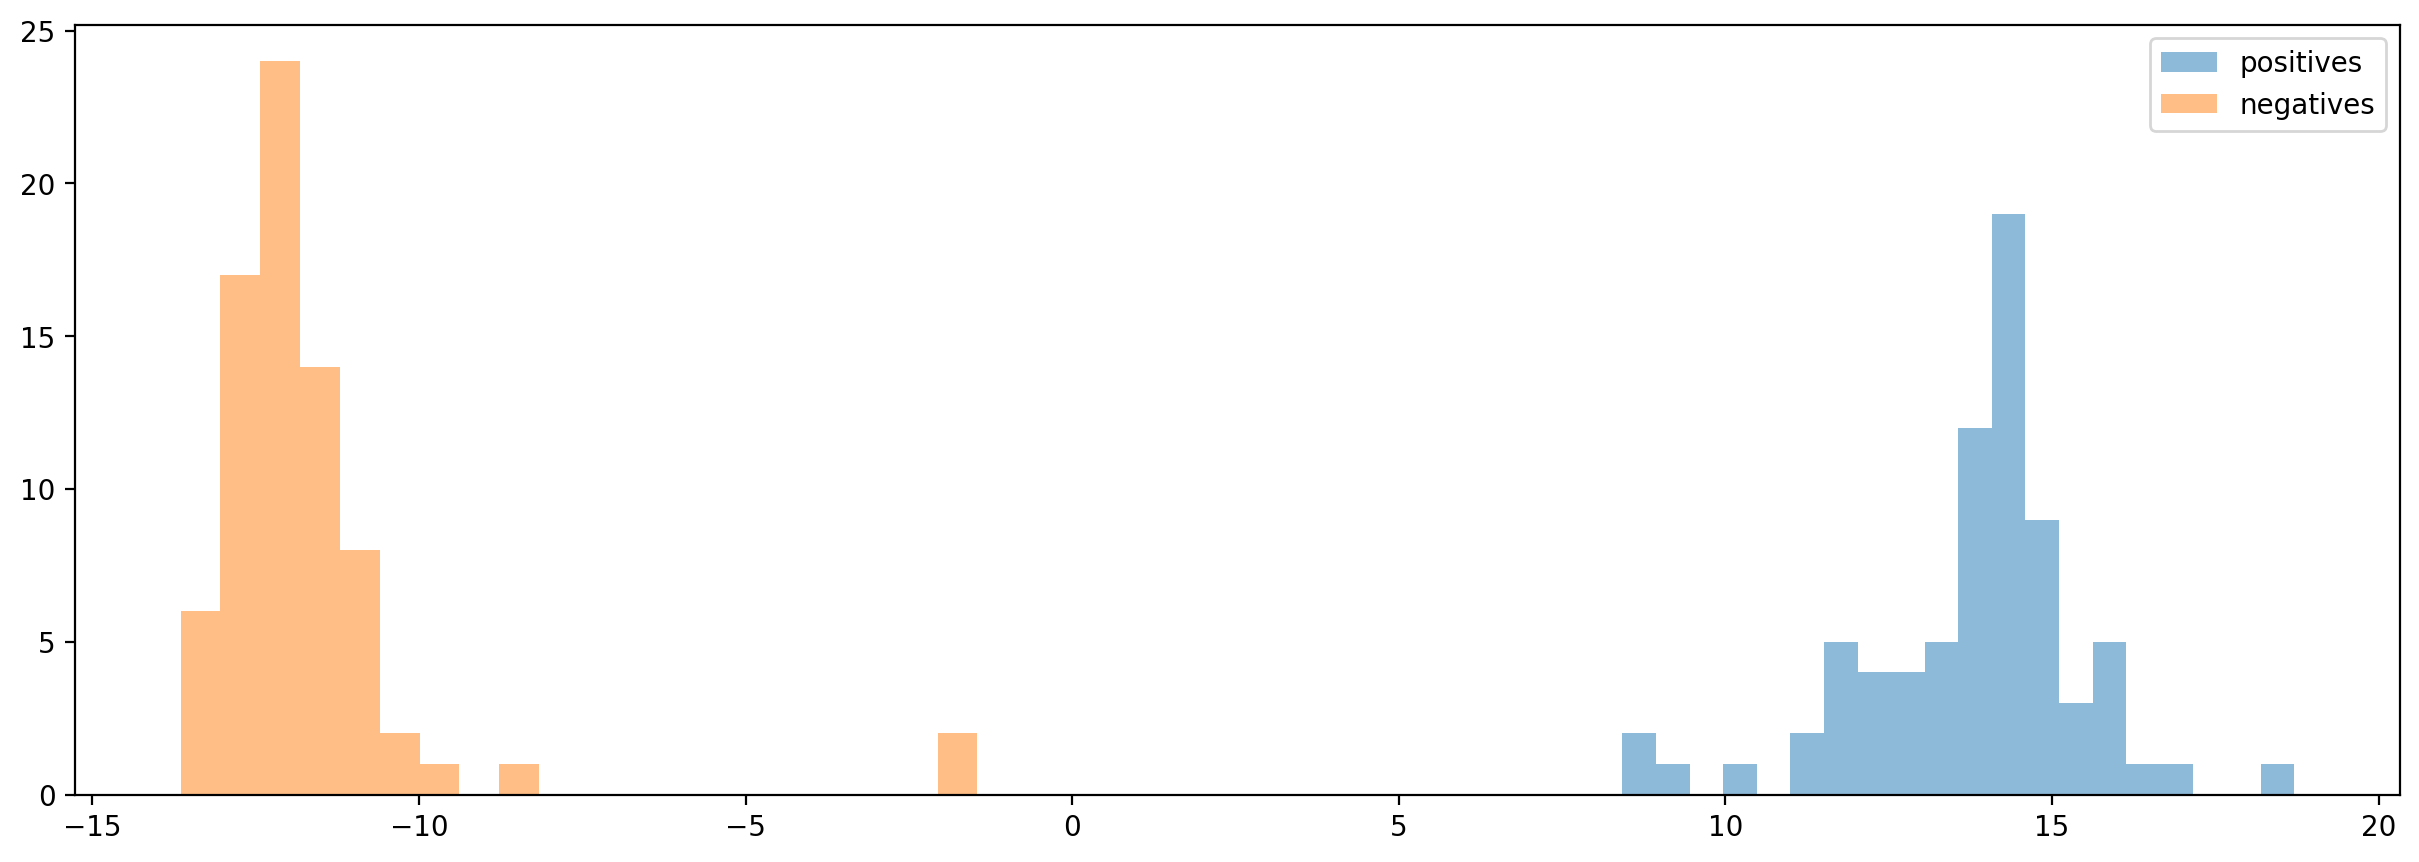

In [52]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_75 = roc_auc_score(labels_val.values,preds,average=None)

In [53]:
roc_auc_score_75

1.0

Training size 100

In [54]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [55]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.984 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [57]:
emb_train_100 = model.embed(labels_trains['train_size_100'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999979166666667 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999395833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.9994375 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999770833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: Use

In [58]:
emb_train_100 = torch.tensor(emb_train_100, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_100.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_100 = emb_train_100.view(emb_train_100.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_100: {emb_train_100.shape}")

Original shape of emb_train: torch.Size([200, 512])
Reshaped emb_train_100: torch.Size([200, 1, 32, 16])


In [59]:
emb_train_100 = emb_train_100.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [60]:
import torch.nn as nn

model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [61]:
quick_fit(model.network, emb_train_100, labels_trains['train_size_100'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 1.0616329745971598e-05, Val Loss: 0.00047862366773188114
val AU ROC: 1.000
val MAP: 1.000
Epoch 200/1000, Loss: 7.787045433360618e-06, Val Loss: 0.00026603398146107793
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 6.561783266079146e-06, Val Loss: 0.00015555883874185383
val AU ROC: 1.000
val MAP: 1.000
Epoch 400/1000, Loss: 5.65361824556021e-06, Val Loss: 0.00010625240975059569
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 4.949800313625019e-06, Val Loss: 8.01496280473657e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 4.372899638838135e-06, Val Loss: 6.363661668729037e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 3.904008281097049e-06, Val Loss: 5.220239836489782e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 3.5147029393556295e-06, Val Loss: 4.361718674772419e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 900/1000, Loss: 3.1627341741113923e-06, Val Loss: 3.753624696400948e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/1406550891.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


1.0

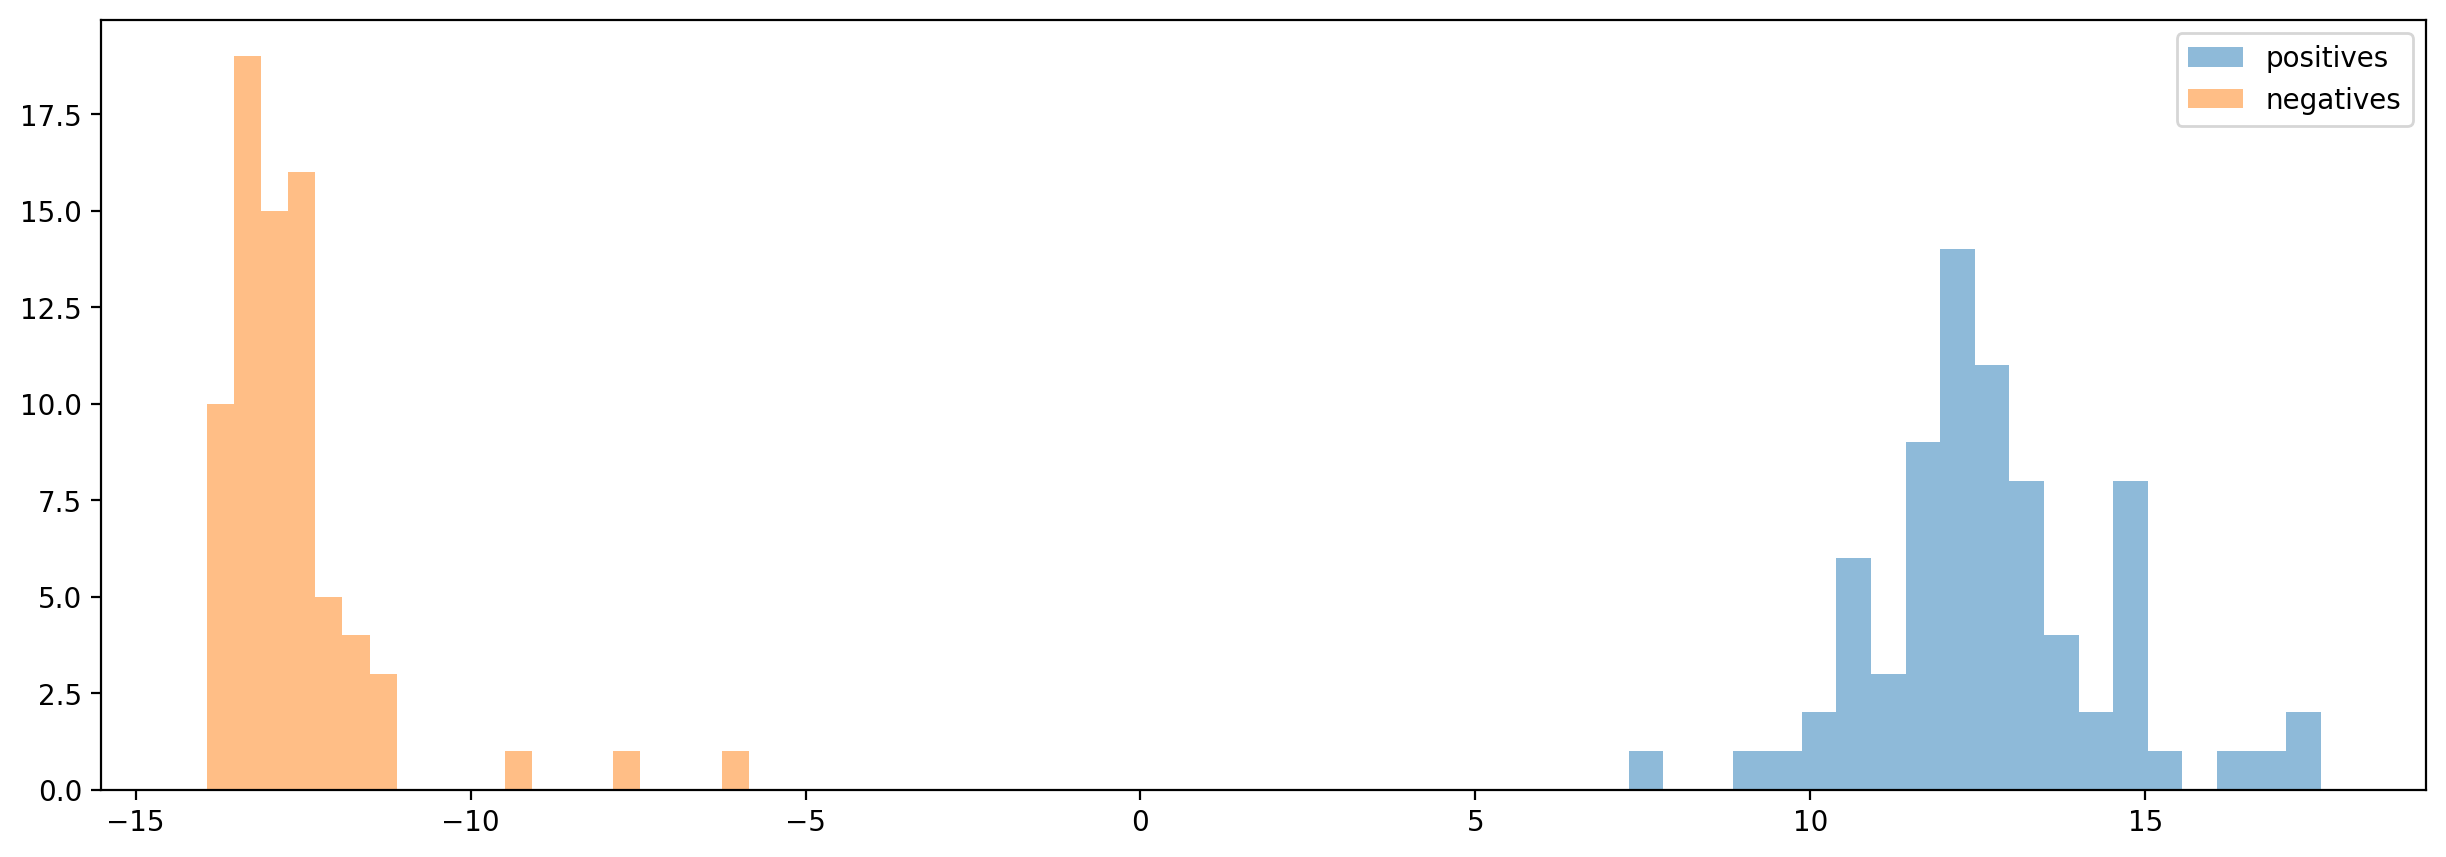

In [62]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_100 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_100

Training size 125

In [63]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [64]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.984 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [65]:
emb_train_125 = model.embed(labels_trains['train_size_125'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999979166666667 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999395833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.9994375 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999770833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: Use

In [66]:
emb_train_125 = torch.tensor(emb_train_125, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_125.shape}")

height, width = 32, 16  # Ensure height * width = 512
emb_train_125 = emb_train_125.view(emb_train_125.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_100: {emb_train_125.shape}")

Original shape of emb_train: torch.Size([250, 512])
Reshaped emb_train_100: torch.Size([250, 1, 32, 16])


In [67]:
emb_train_125 = emb_train_125.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [68]:
import torch.nn as nn

model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [69]:
quick_fit(model.network, emb_train_125, labels_trains['train_size_125'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 2.0819097699131817e-05, Val Loss: 0.07781026512384415
val AU ROC: 1.000
val MAP: 1.000
Epoch 200/1000, Loss: 1.4261275282478891e-05, Val Loss: 0.08578638732433319
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 1.1044376151403412e-05, Val Loss: 0.09148227423429489
val AU ROC: 1.000
val MAP: 1.000
Epoch 400/1000, Loss: 9.021134246722795e-06, Val Loss: 0.09625031799077988
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 7.514096523664193e-06, Val Loss: 0.09835164248943329
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 6.401945483958116e-06, Val Loss: 0.10094120353460312
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 5.5079517551348545e-06, Val Loss: 0.10500147193670273
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 4.791427272721194e-06, Val Loss: 0.11069648712873459
val AU ROC: 1.000
val MAP: 1.000
Epoch 900/1000, Loss: 4.2107249100808986e-06, Val Loss: 0.11503125727176666
val AU ROC: 1.000
val MAP: 1.000
Epoch 1000/1000, Loss: 

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/3376882458.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


1.0

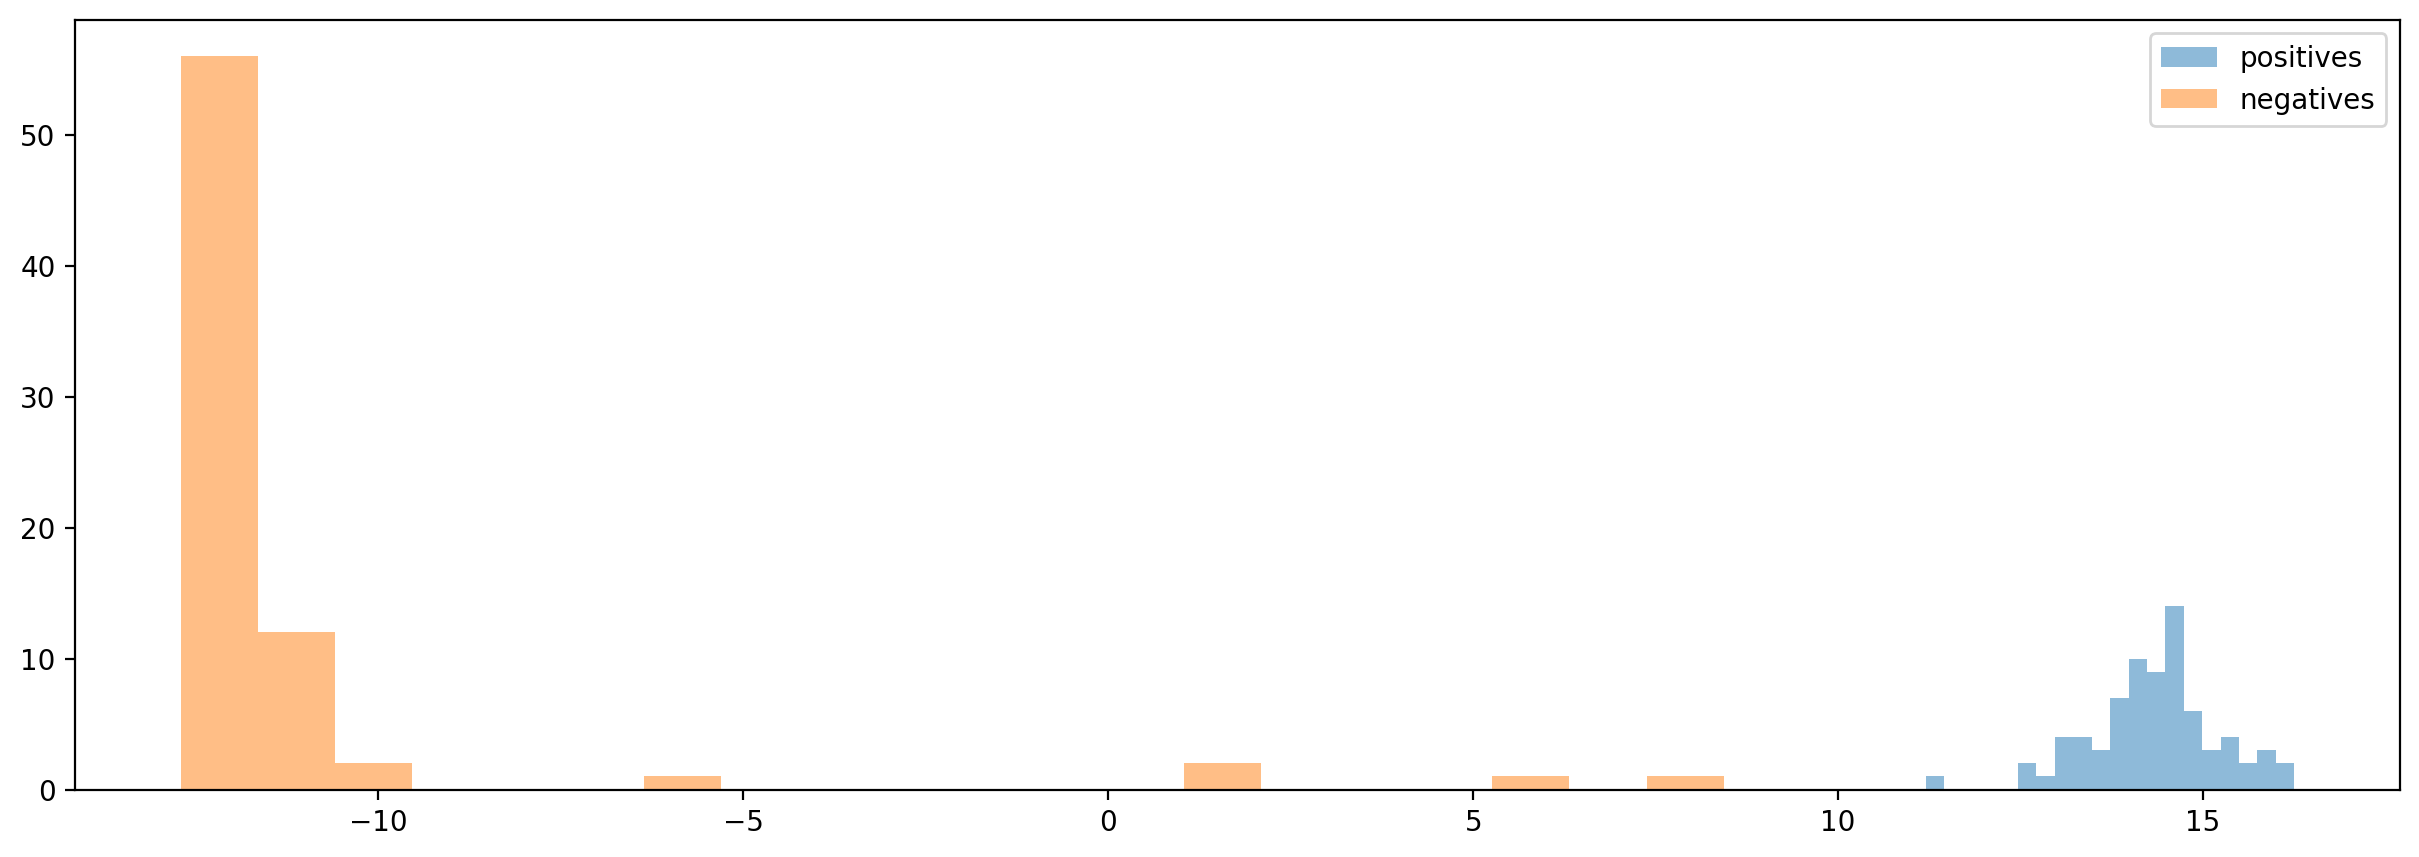

In [70]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_125 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_125

Training size 150

In [71]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [72]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.984 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [73]:
emb_train_150 = model.embed(labels_trains['train_size_150'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999979166666667 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999395833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.9994375 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999770833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: Use

In [74]:
emb_train_150 = torch.tensor(emb_train_150, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_150.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_150 = emb_train_150.view(emb_train_150.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_150: {emb_train_150.shape}")

Original shape of emb_train: torch.Size([300, 512])
Reshaped emb_train_150: torch.Size([300, 1, 32, 16])


In [75]:
emb_train_150 = emb_train_150.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [76]:
import torch.nn as nn

model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [77]:
quick_fit(model.network, emb_train_150, labels_trains['train_size_150'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 1.0155920790566597e-05, Val Loss: 0.08759916573762894
val AU ROC: 0.976
val MAP: 0.976
Epoch 200/1000, Loss: 6.779608611395815e-06, Val Loss: 0.08305750042200089
val AU ROC: 0.984
val MAP: 0.984
Epoch 300/1000, Loss: 5.440575478132814e-06, Val Loss: 0.0812305137515068
val AU ROC: 0.990
val MAP: 0.990
Epoch 400/1000, Loss: 4.6172690417733975e-06, Val Loss: 0.08031587302684784
val AU ROC: 0.994
val MAP: 0.994
Epoch 500/1000, Loss: 3.979819666710682e-06, Val Loss: 0.07982711493968964
val AU ROC: 0.995
val MAP: 0.995
Epoch 600/1000, Loss: 3.5131147342326585e-06, Val Loss: 0.07962032407522202
val AU ROC: 0.996
val MAP: 0.996
Epoch 700/1000, Loss: 3.1250306165020447e-06, Val Loss: 0.07958193123340607
val AU ROC: 0.996
val MAP: 0.996
Epoch 800/1000, Loss: 2.7777998639066936e-06, Val Loss: 0.07957635819911957
val AU ROC: 0.996
val MAP: 0.996
Epoch 900/1000, Loss: 2.5111992272286443e-06, Val Loss: 0.07960883527994156
val AU ROC: 0.997
val MAP: 0.997
Epoch 1000/1000, Loss: 

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/1953958238.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.9975111111111111

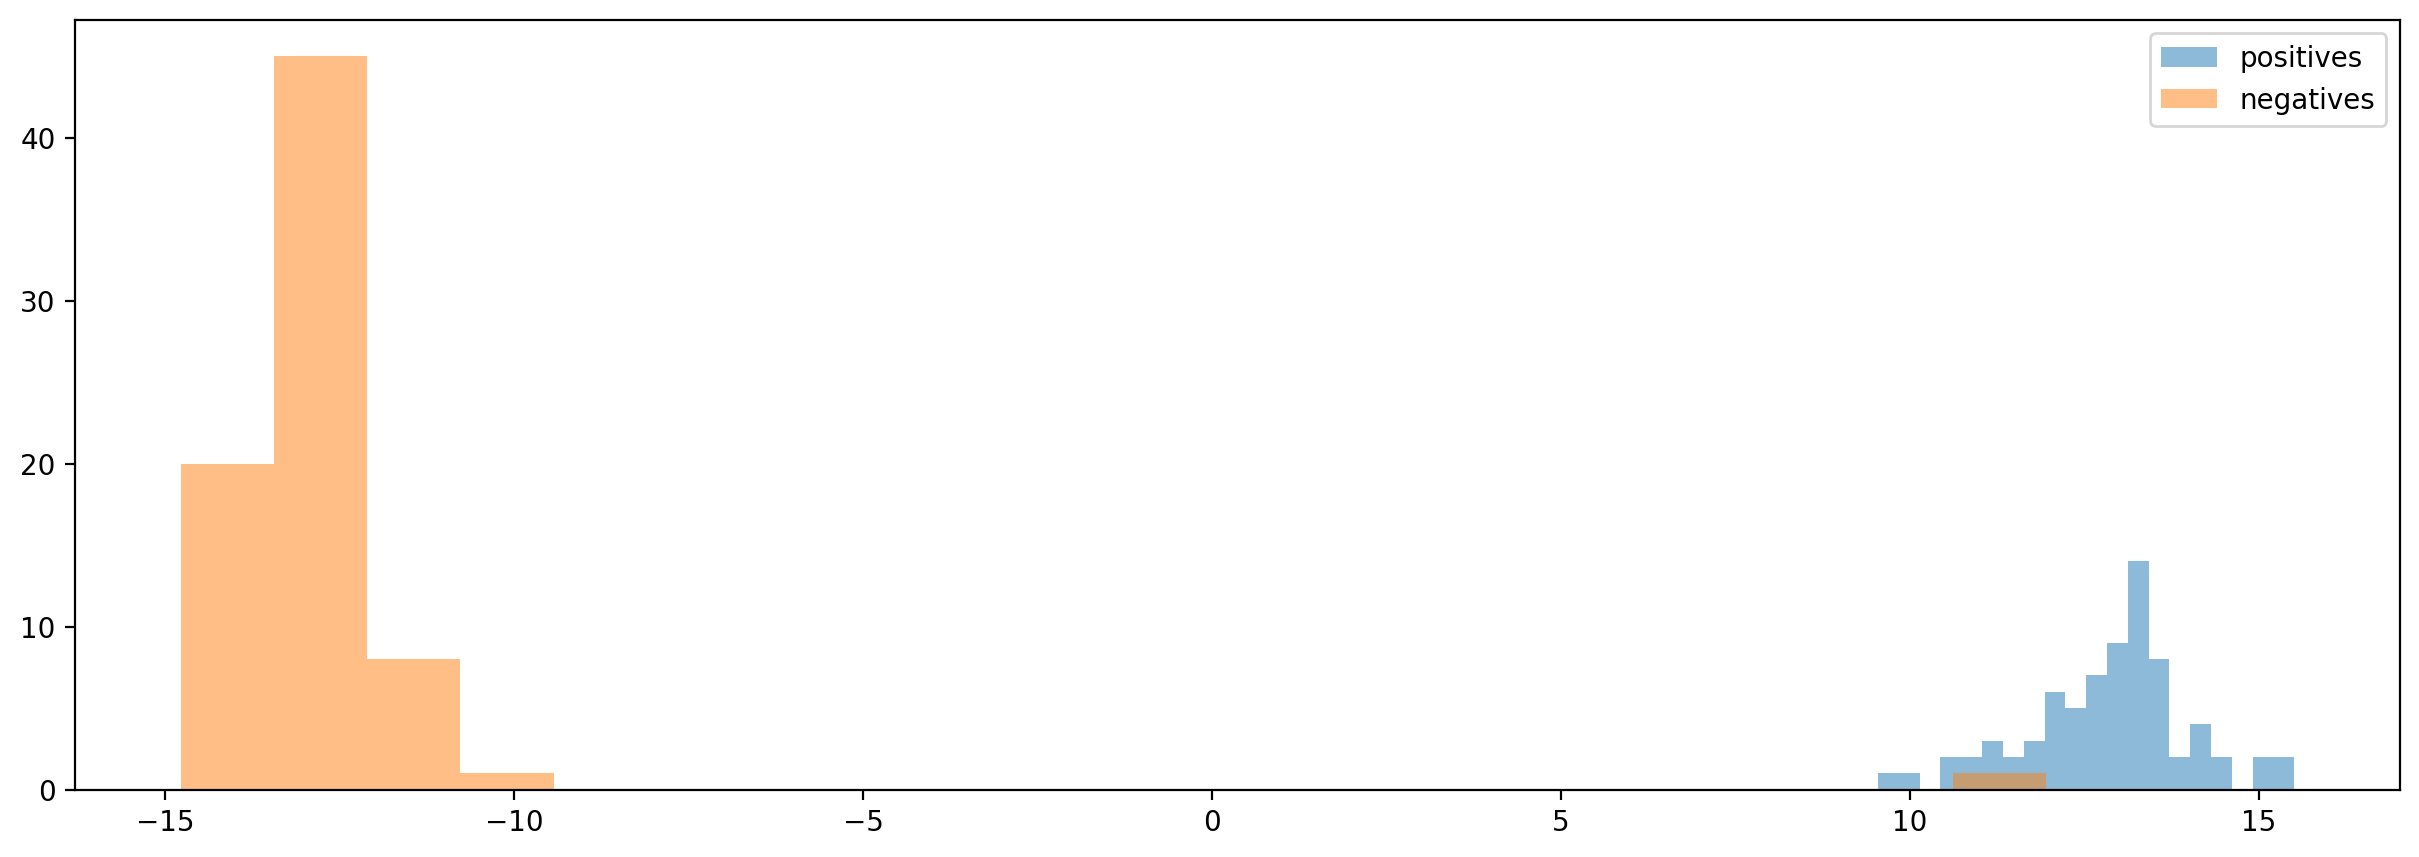

In [78]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_150 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_150

Training size 175

In [79]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [80]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.984 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [81]:
emb_train_175 = model.embed(labels_trains['train_size_175'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/11 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999979166666667 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999395833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.9994375 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999770833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: Use

In [82]:
emb_train_175 = torch.tensor(emb_train_175, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_175.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_175 = emb_train_175.view(emb_train_175.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_175: {emb_train_175.shape}")

Original shape of emb_train: torch.Size([350, 512])
Reshaped emb_train_175: torch.Size([350, 1, 32, 16])


In [83]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [84]:
emb_train_175 = emb_train_175.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [85]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [86]:
quick_fit(model.network, emb_train_175, labels_trains['train_size_175'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 1.606588193681091e-05, Val Loss: 0.0003345150616951287
val AU ROC: 1.000
val MAP: 1.000
Epoch 200/1000, Loss: 1.0807374565047212e-05, Val Loss: 6.31889997748658e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 8.547650395485107e-06, Val Loss: 3.136394661851227e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 400/1000, Loss: 7.215246114355978e-06, Val Loss: 2.278645297337789e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 6.3184115788317285e-06, Val Loss: 1.8797896700561978e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 5.626366601063637e-06, Val Loss: 1.6206980944843963e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 5.057896942162188e-06, Val Loss: 1.4359078704728745e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 4.589184754877351e-06, Val Loss: 1.3096102520648856e-05
val AU ROC: 1.000
val MAP: 1.000


KeyboardInterrupt: 

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/2433222695.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


1.0

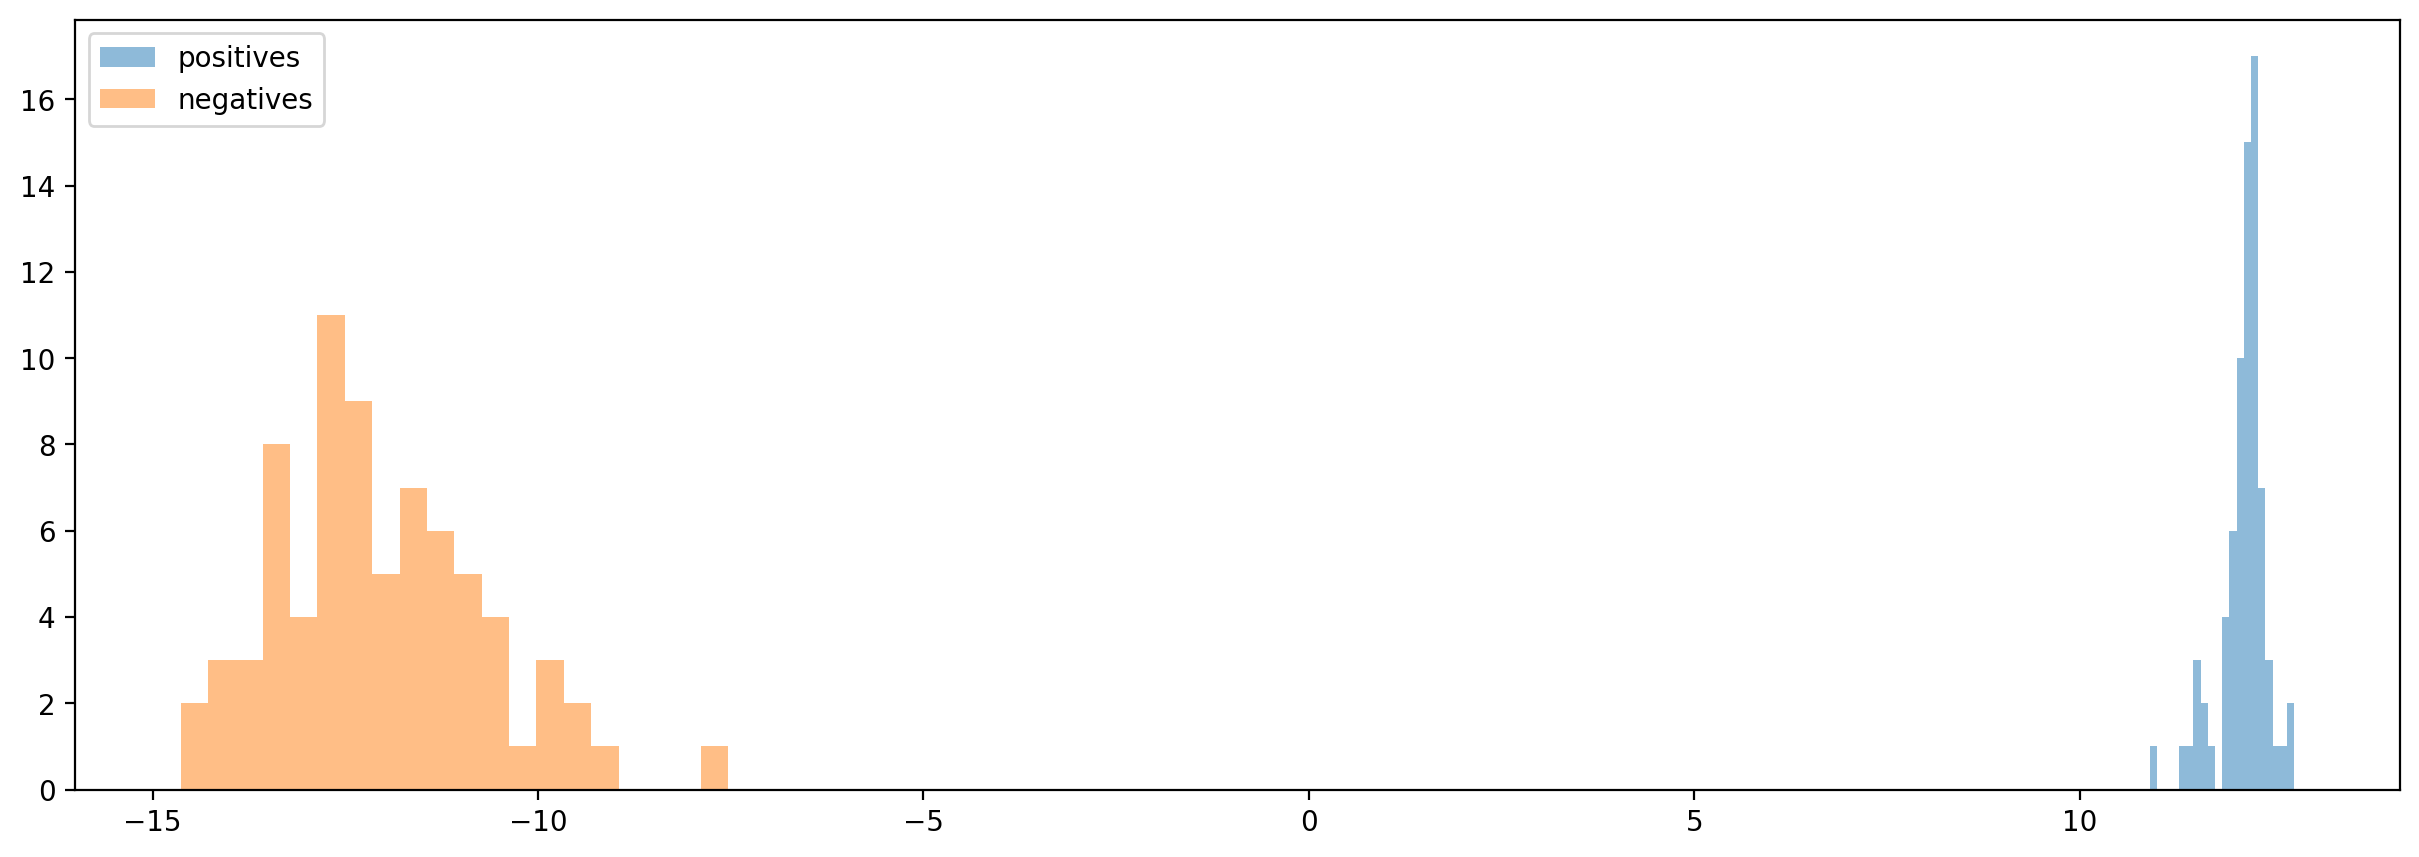

In [87]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_175 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_175

Training size 200

In [88]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [89]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.984 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [90]:
emb_train_200 = model.embed(labels_trains['train_size_200'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/13 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999979166666667 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999395833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.9994375 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999770833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: Use

In [91]:
emb_train_200 = torch.tensor(emb_train_200, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_200.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_200 = emb_train_200.view(emb_train_200.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_200: {emb_train_200.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

Original shape of emb_train: torch.Size([400, 512])
Reshaped emb_train_200: torch.Size([400, 1, 32, 16])
Reshaped emb_val: torch.Size([150, 1, 32, 16])


In [92]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [93]:
emb_train_200 = emb_train_200.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [94]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [95]:
quick_fit(model.network, emb_train_200, labels_trains['train_size_200'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


KeyboardInterrupt: 

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/1978695488.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.9811555555555556

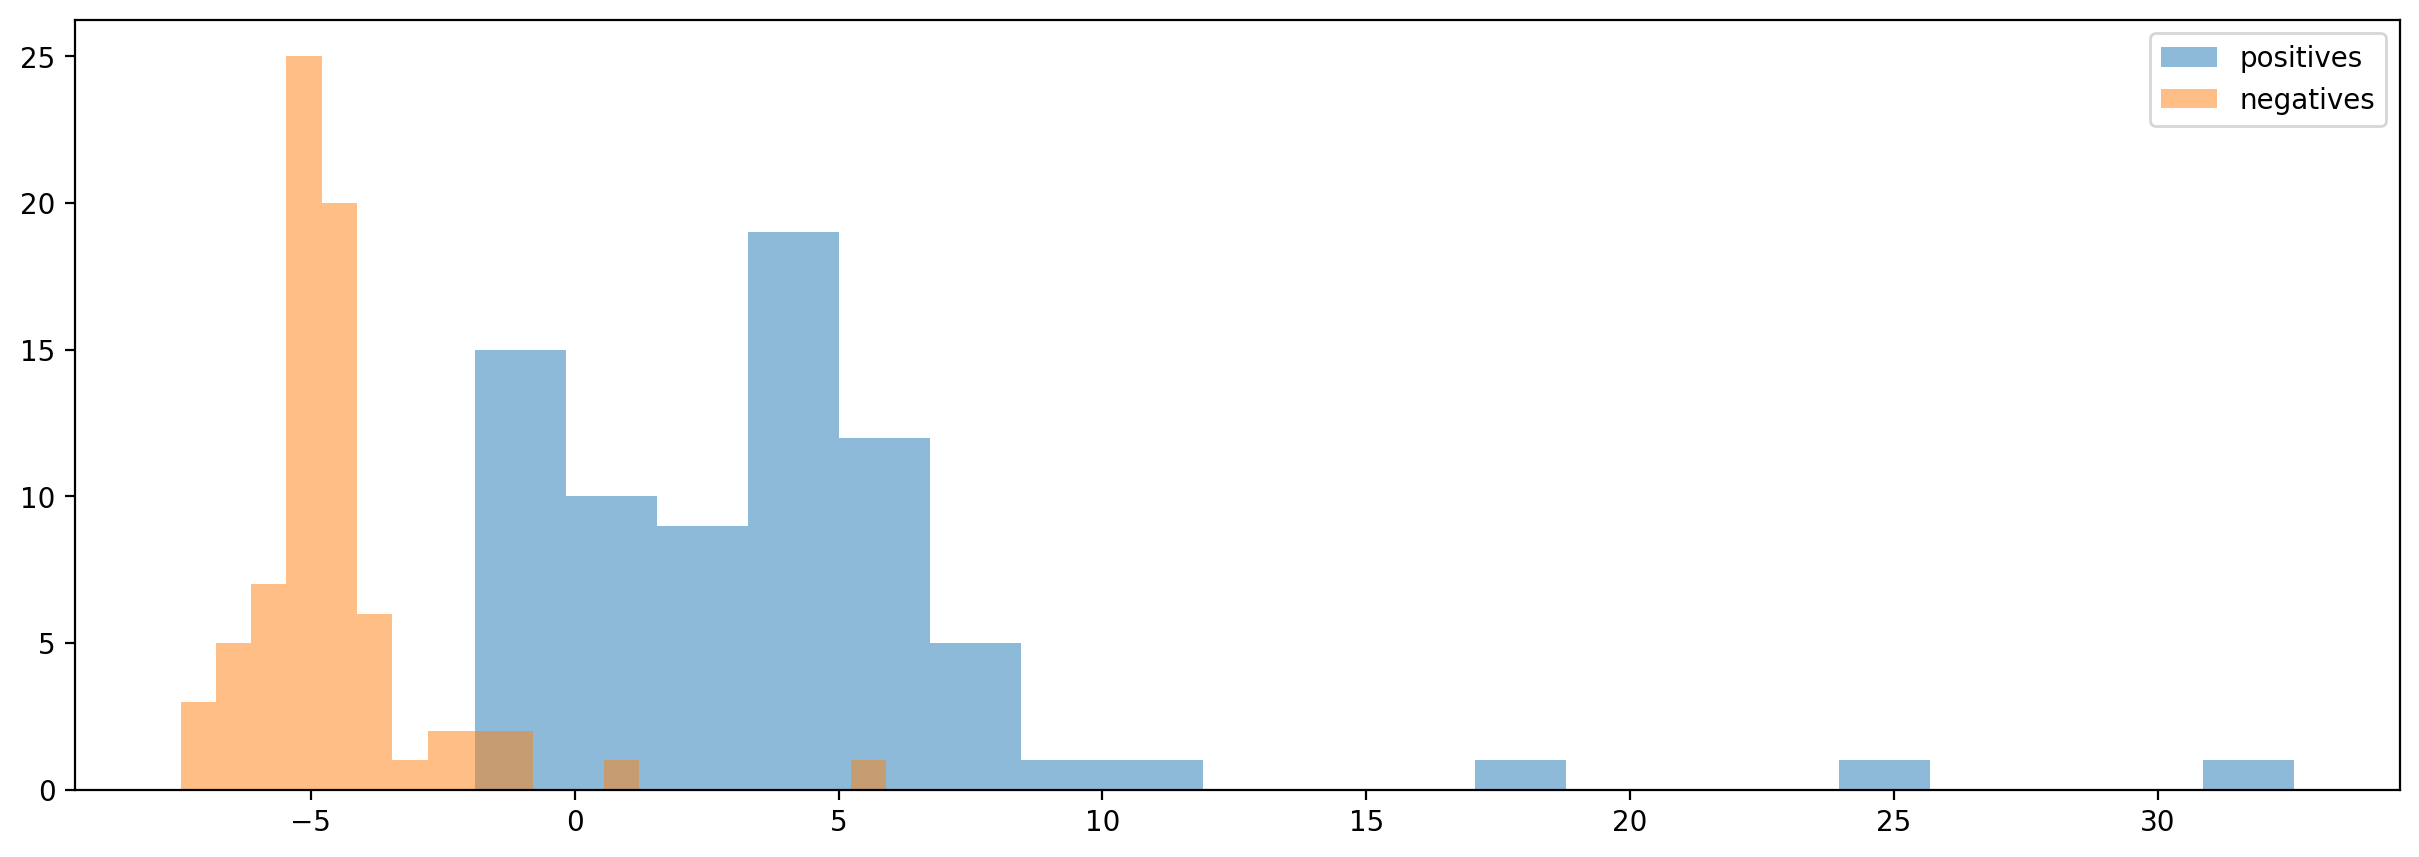

In [96]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_200 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_200

Training size 225

In [106]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [107]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.984 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [108]:
emb_train_225 = model.embed(labels_trains['train_size_225'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/15 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999979166666667 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999395833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.9994375 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999770833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: Use

In [109]:
emb_train_225 = torch.tensor(emb_train_225, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_225.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_225 = emb_train_225.view(emb_train_225.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_225: {emb_train_225.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

Original shape of emb_train: torch.Size([450, 512])
Reshaped emb_train_225: torch.Size([450, 1, 32, 16])
Reshaped emb_val: torch.Size([150, 1, 32, 16])


In [110]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [111]:
emb_train_225 = emb_train_225.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [112]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [113]:
quick_fit(model.network, emb_train_225, labels_trains['train_size_225'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 2.8561580620589666e-05, Val Loss: 4.180406540399417e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 200/1000, Loss: 1.9031171177630313e-05, Val Loss: 2.9623086447827518e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 1.4308134268503636e-05, Val Loss: 2.2546893887920305e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 400/1000, Loss: 1.1286279004707467e-05, Val Loss: 1.797480581444688e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 9.150880032393616e-06, Val Loss: 1.4940841538191307e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 7.6214978435018566e-06, Val Loss: 1.2668123417824972e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 6.4455048232048284e-06, Val Loss: 1.0944773748633452e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 5.550295099965297e-06, Val Loss: 9.578438039170578e-06
val AU ROC: 1.000
val MAP: 1.000
Epoch 900/1000, Loss: 4.822879418497905e-06, Val Loss: 8.523846190655604e-06
val AU ROC: 1.000
val MAP: 1.000

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/1751666026.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


1.0

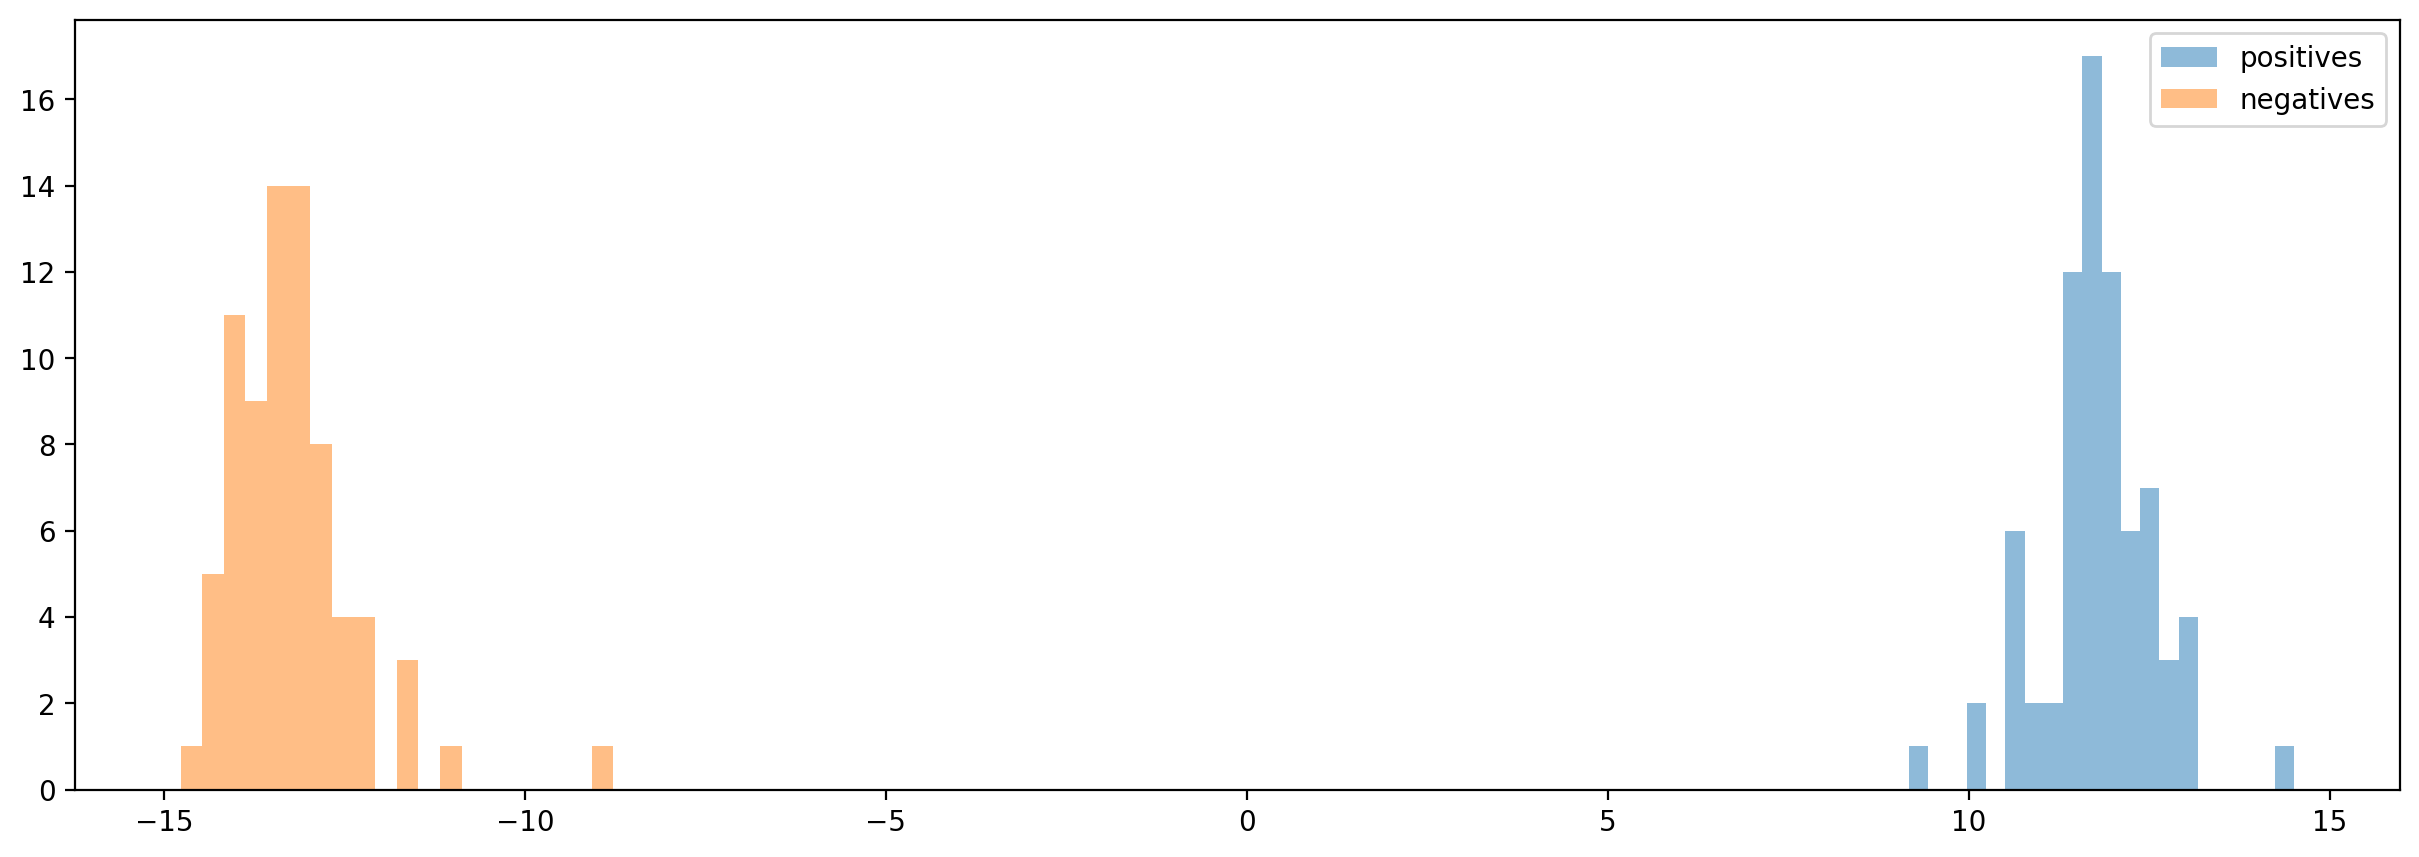

In [114]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_225 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_225

Training size 250

In [115]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [116]:
emb_train_250 = model.embed(labels_trains['train_size_250'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/16 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999979166666667 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999395833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.9994375 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999770833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: Use

In [117]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.984 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [118]:
emb_train_250 = torch.tensor(emb_train_250, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_250.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_250 = emb_train_250.view(emb_train_250.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_250: {emb_train_250.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

Original shape of emb_train: torch.Size([500, 512])
Reshaped emb_train_250: torch.Size([500, 1, 32, 16])
Reshaped emb_val: torch.Size([150, 1, 32, 16])


In [119]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [120]:
emb_train_250 = emb_train_250.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [121]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [122]:
quick_fit(model.network, emb_train_250, labels_trains['train_size_250'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 2.4175371436285786e-05, Val Loss: 0.0008700967882759869
val AU ROC: 1.000
val MAP: 1.000
Epoch 200/1000, Loss: 1.58411876327591e-05, Val Loss: 0.0009920749580487609
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 1.2189264452899806e-05, Val Loss: 0.0011467048898339272
val AU ROC: 1.000
val MAP: 1.000
Epoch 400/1000, Loss: 9.836306162469555e-06, Val Loss: 0.0007254013908095658
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 8.185921615222469e-06, Val Loss: 0.0012841918505728245
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 7.040583113848697e-06, Val Loss: 0.0017519801622256637
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 6.149770342744887e-06, Val Loss: 0.001592931803315878
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 5.417135980678722e-06, Val Loss: 0.0013698688708245754
val AU ROC: 1.000
val MAP: 1.000
Epoch 900/1000, Loss: 4.8122519729076885e-06, Val Loss: 0.00135832151863724
val AU ROC: 1.000
val MAP: 1.000
Epoch 1000/

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/3342173857.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


1.0

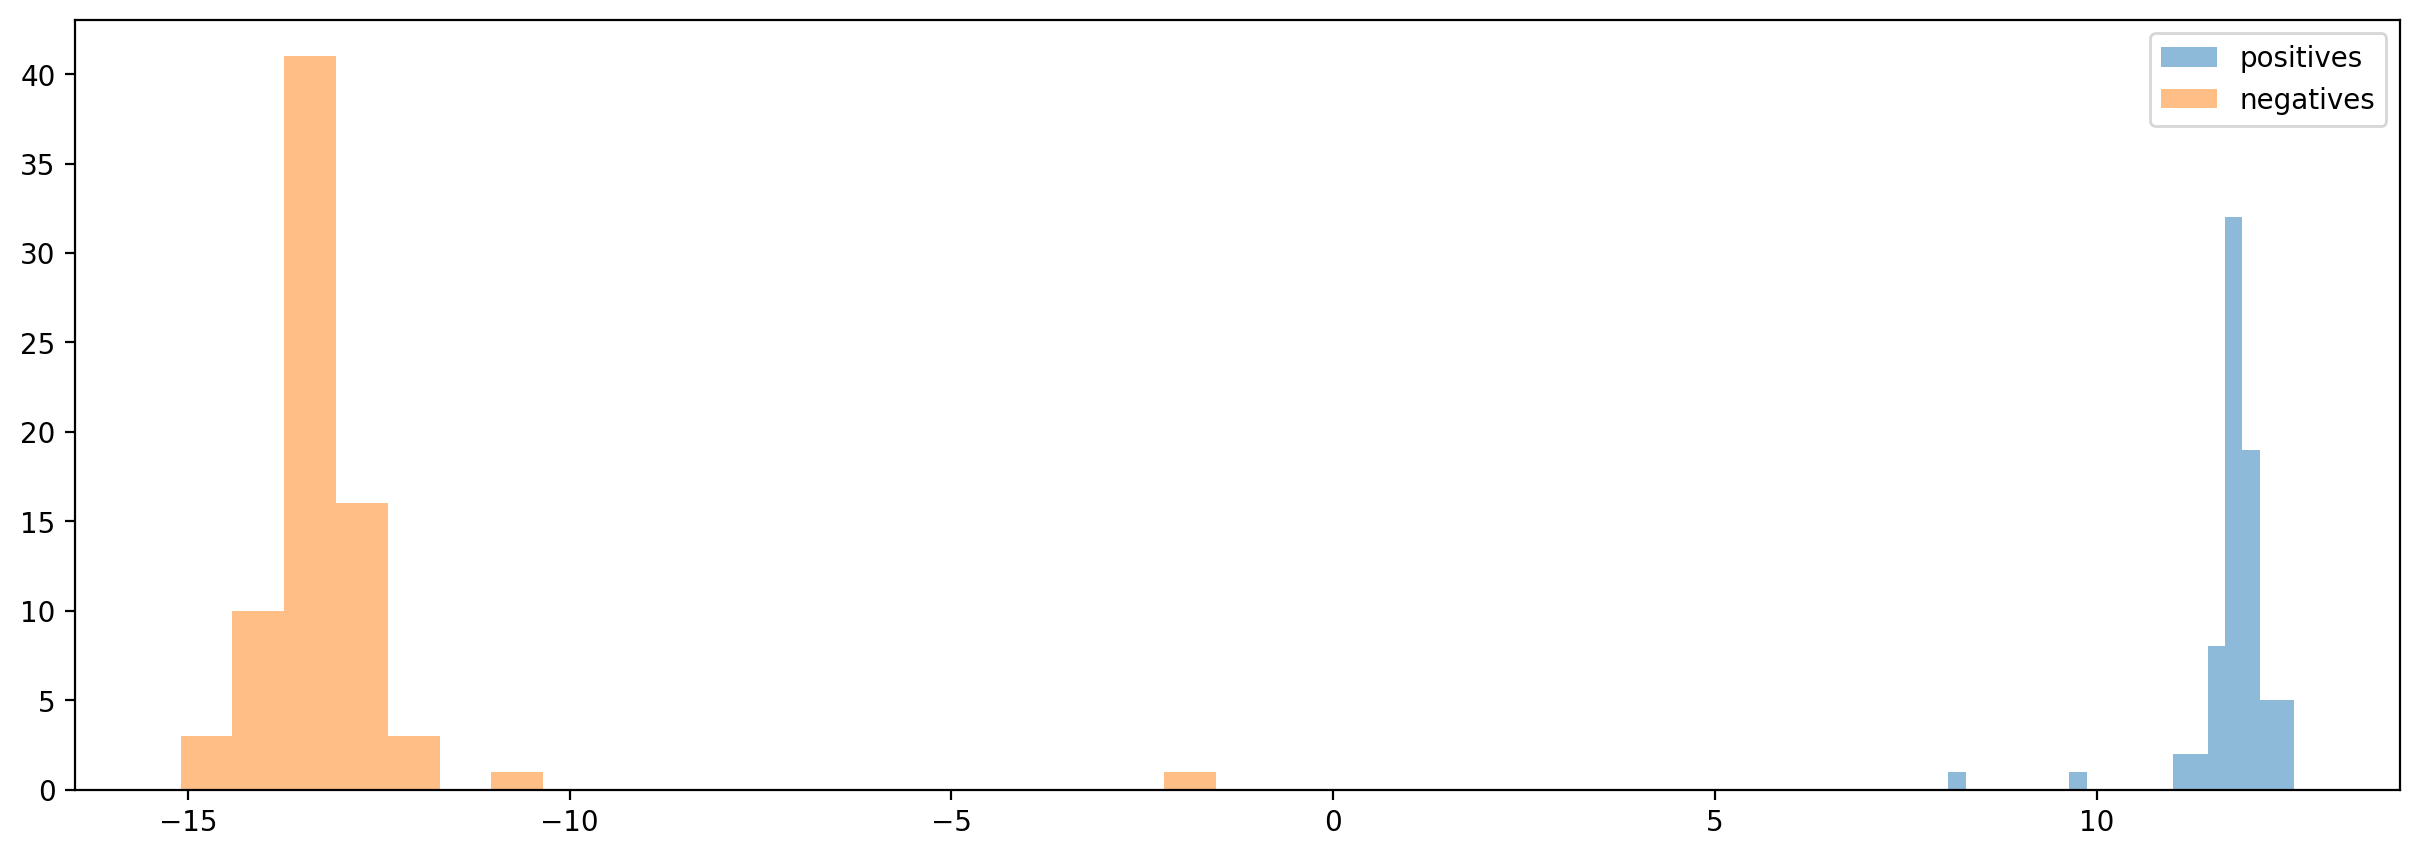

In [123]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_250 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_250

Training size 275

In [124]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [125]:
emb_train_275 = model.embed(labels_trains['train_size_275'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/18 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999979166666667 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999395833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.9994375 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999770833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: Use

In [126]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.984 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [127]:
emb_train_275 = torch.tensor(emb_train_275, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_275.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_275 = emb_train_275.view(emb_train_275.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_275: {emb_train_275.shape}")


Original shape of emb_train: torch.Size([550, 512])
Reshaped emb_train_275: torch.Size([550, 1, 32, 16])


In [128]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [129]:
emb_train_275 = emb_train_275.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [130]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [131]:
quick_fit(model.network, emb_train_275, labels_trains['train_size_275'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 1.212053575727623e-05, Val Loss: 6.78971700835973e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 200/1000, Loss: 7.793396434863098e-06, Val Loss: 3.606712562032044e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 6.072766154829878e-06, Val Loss: 3.1040635803947225e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 400/1000, Loss: 5.012785095459549e-06, Val Loss: 2.9484086553566158e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 4.282355803297833e-06, Val Loss: 2.7667016183841042e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 3.7143311146792257e-06, Val Loss: 2.5417639335501008e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 3.241741751480731e-06, Val Loss: 2.3440516088157892e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 2.8738993478327757e-06, Val Loss: 2.1842244677827694e-05
val AU ROC: 1.000
val MAP: 1.000
Epoch 900/1000, Loss: 2.5694184841995593e-06, Val Loss: 2.0249508452252485e-05
val AU ROC: 1.000
val MAP: 1.000
E

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/872787565.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


1.0

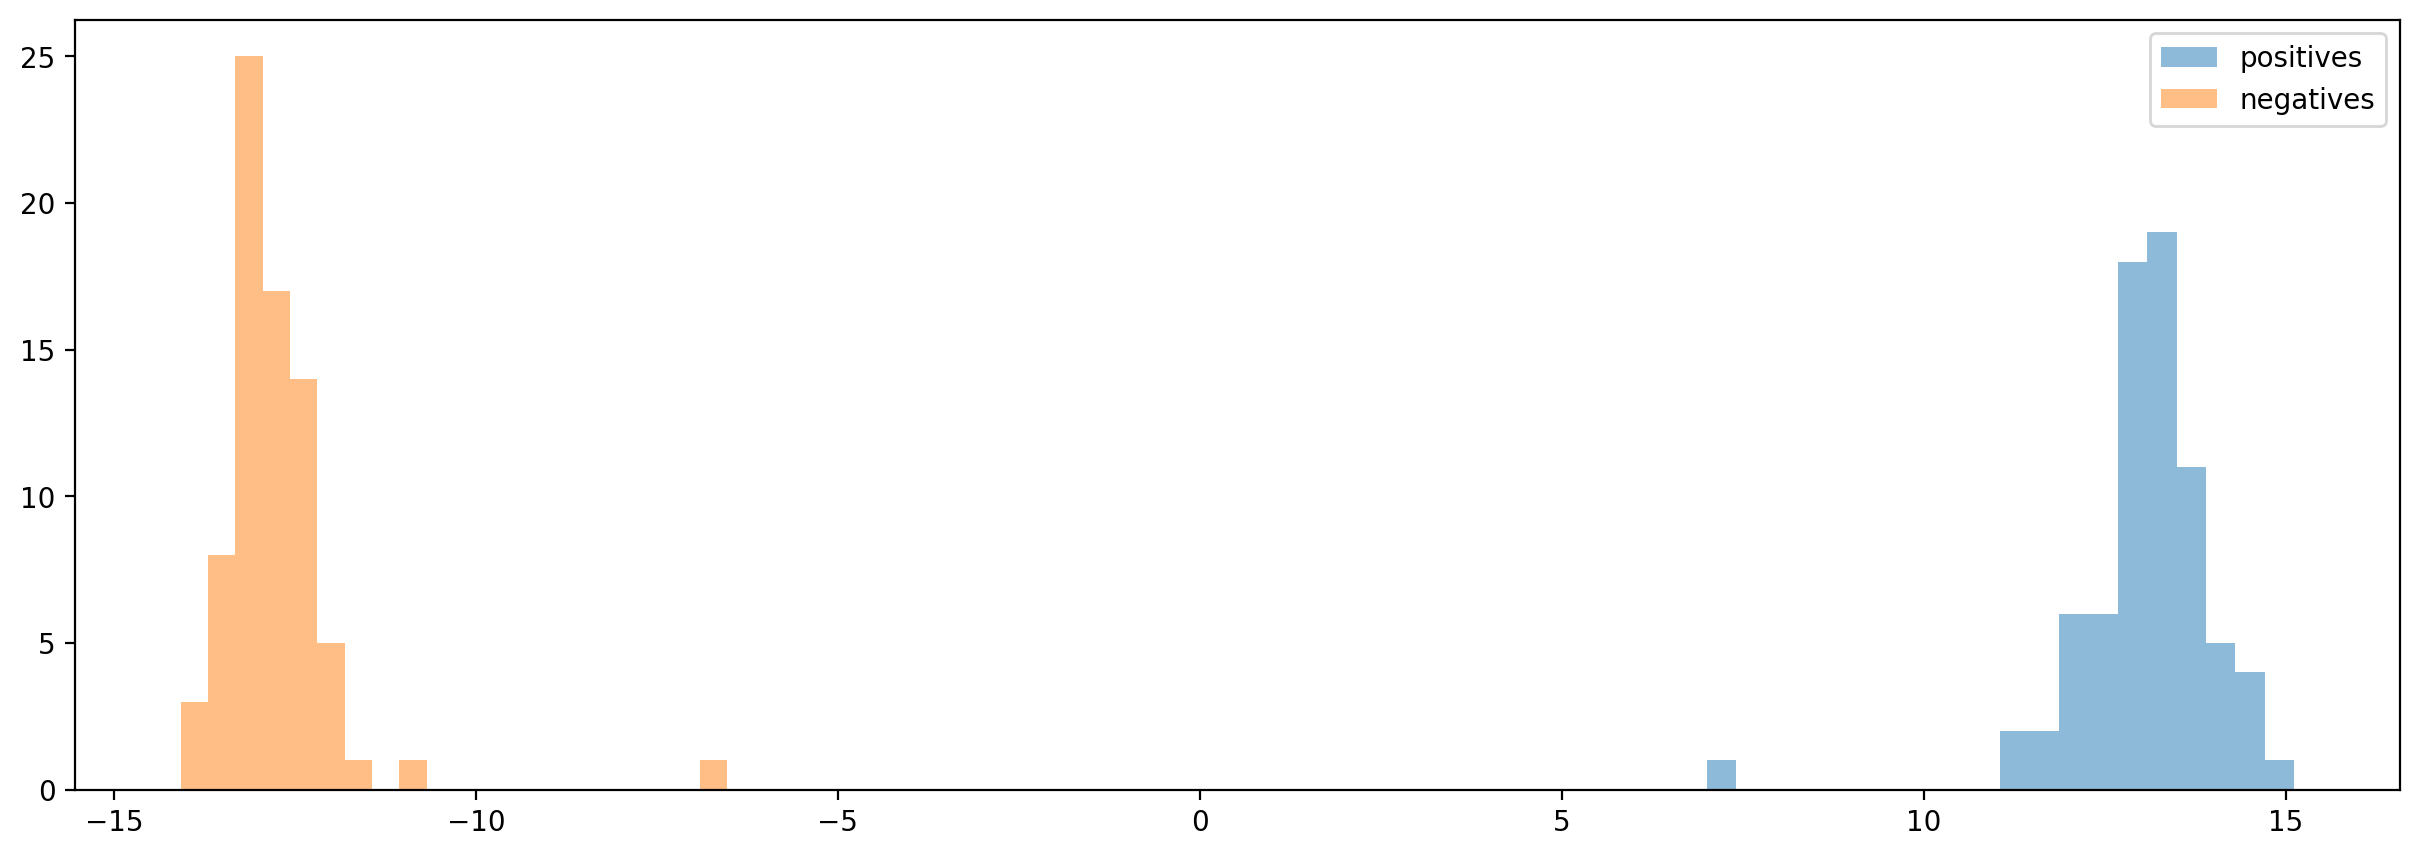

In [132]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_275 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_275

Training size 300

In [133]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [134]:
emb_train_300 = model.embed(labels_trains['train_size_300'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/19 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999979166666667 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999395833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.9994375 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999770833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: Use

In [135]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.984 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [136]:
emb_train_300 = torch.tensor(emb_train_300, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_300.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_300 = emb_train_300.view(emb_train_300.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_300: {emb_train_300.shape}")


Original shape of emb_train: torch.Size([600, 512])
Reshaped emb_train_300: torch.Size([600, 1, 32, 16])


In [137]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [138]:
emb_val = emb_val.repeat(1, 3, 1, 1)
emb_train_300 = emb_train_300.repeat(1, 3, 1, 1) 

In [139]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [140]:
quick_fit(model.network, emb_train_300, labels_trains['train_size_300'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 1.6166082787094638e-05, Val Loss: 0.03518948704004288
val AU ROC: 1.000
val MAP: 1.000


KeyboardInterrupt: 

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3447/3752346880.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.9991111111111112

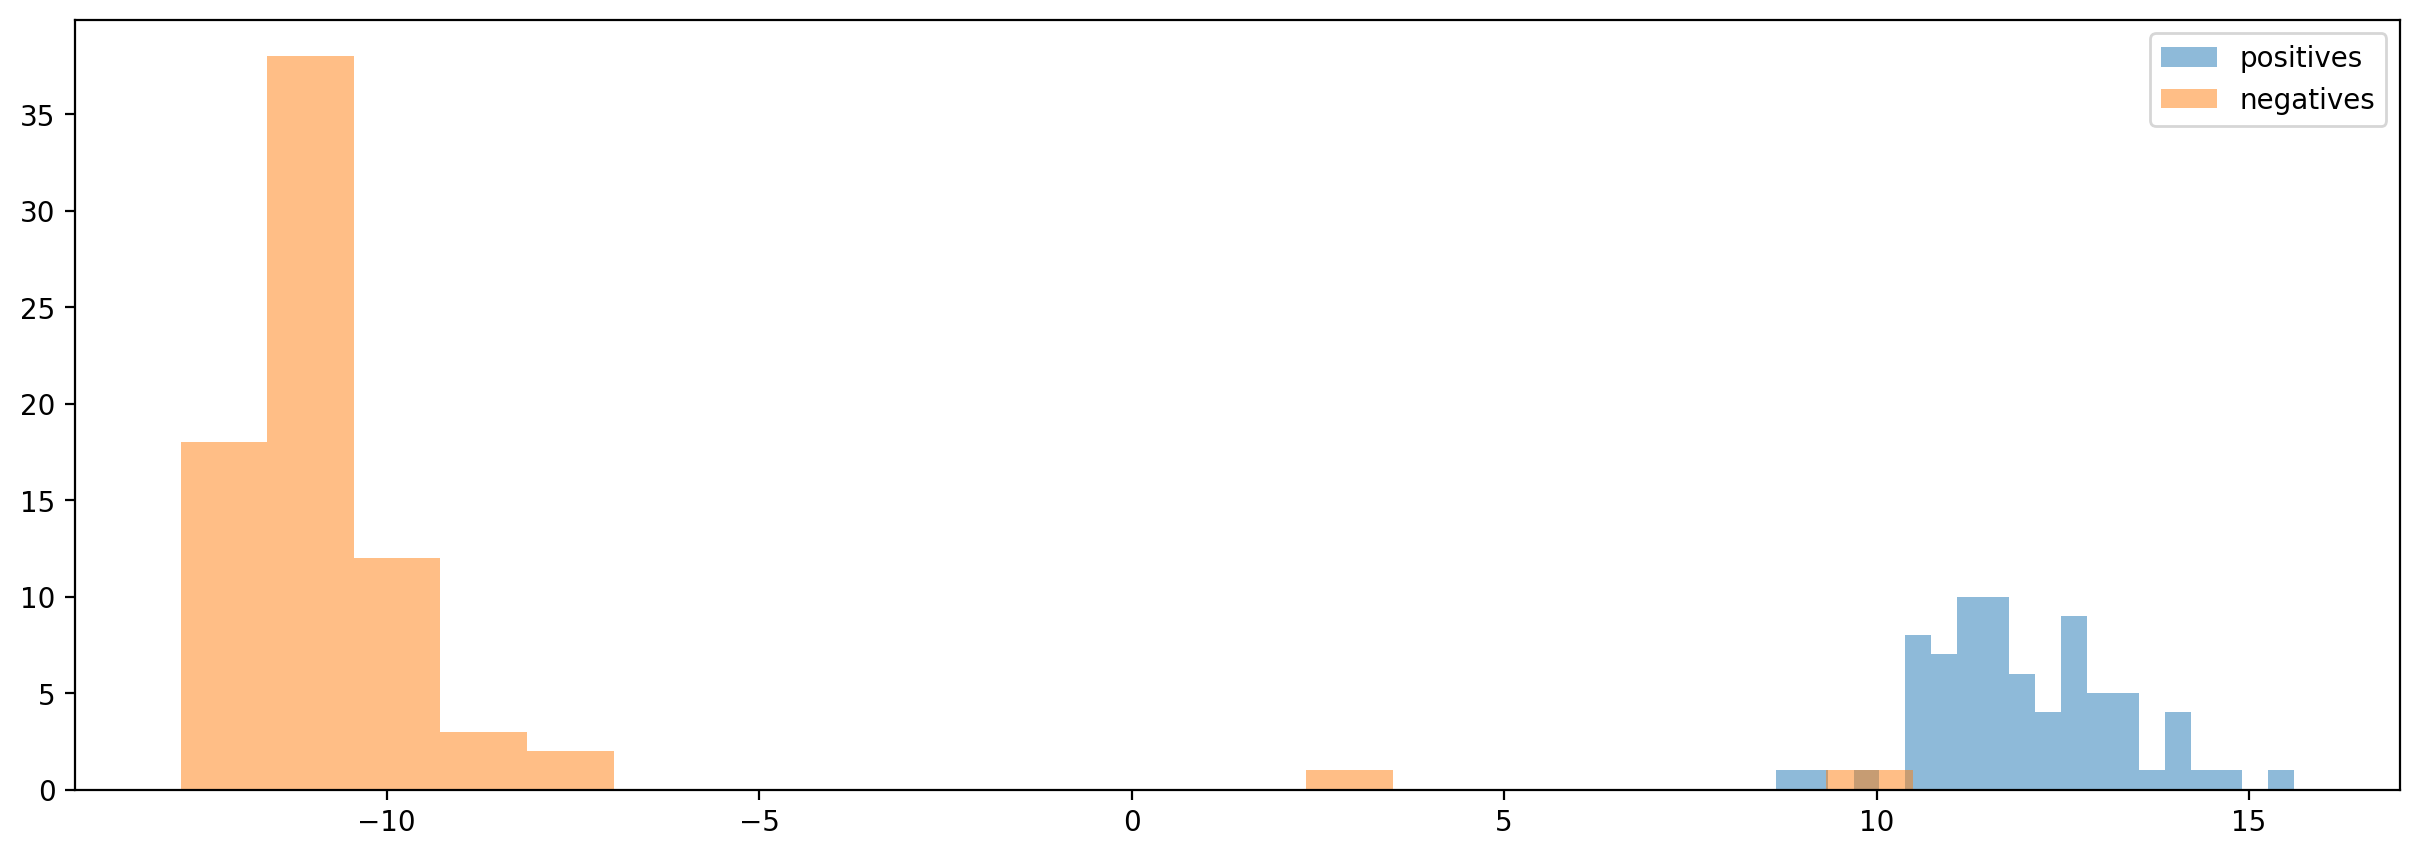

In [141]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_300 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_300

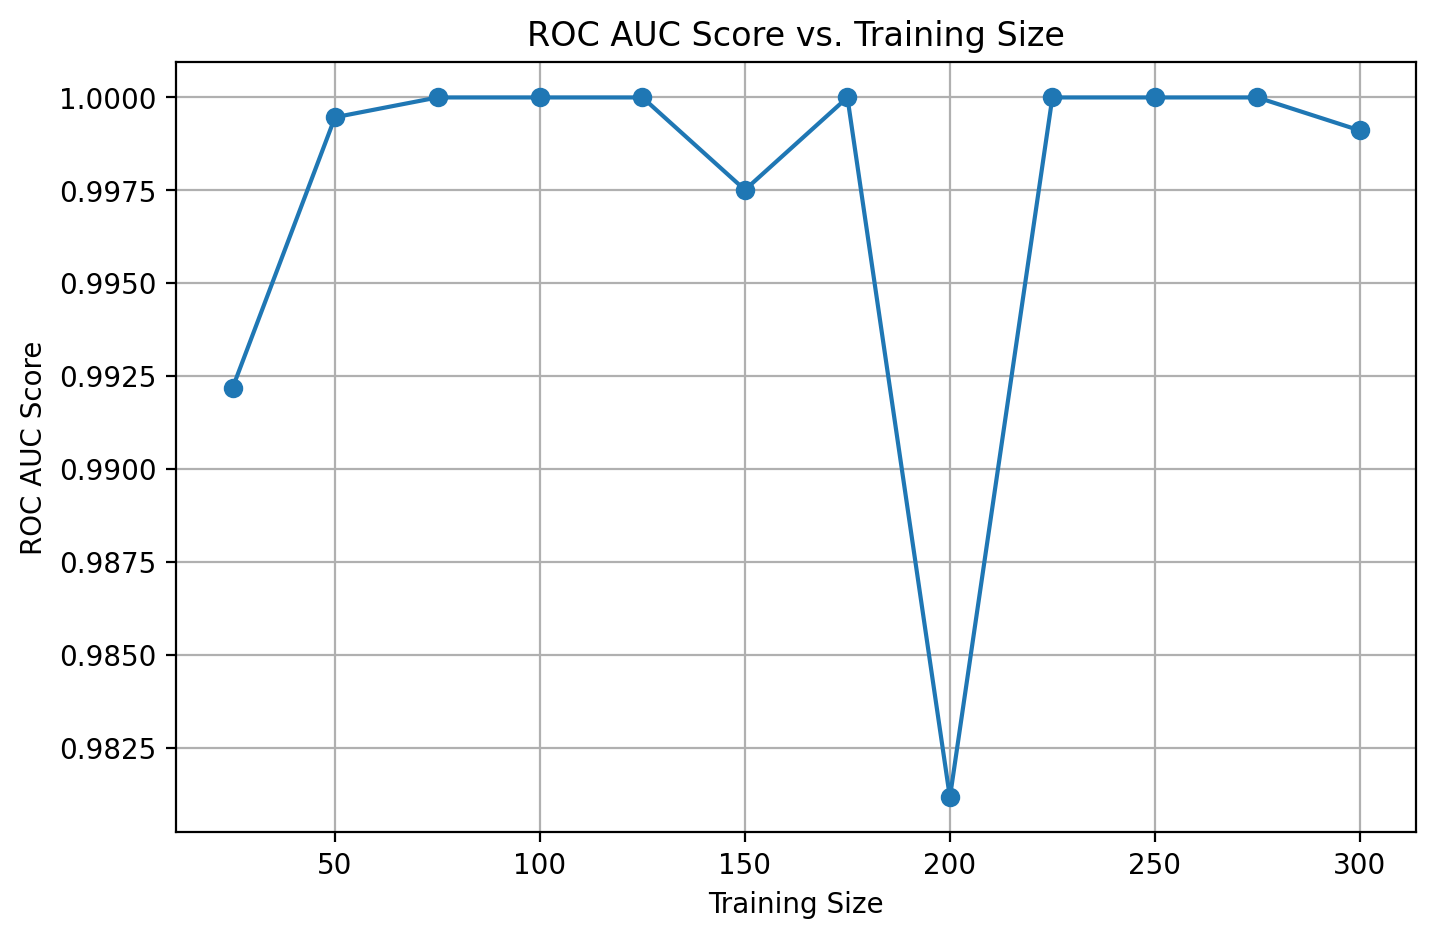

In [142]:
training_sizes = []
roc_auc_scores = []

# Iterate over training sizes and collect the scores
for size in range(25, 301, 25):
    score = eval(f"roc_auc_score_{size}")
    training_sizes.append(size)
    roc_auc_scores.append(score)

# Create a DataFrame
df = pd.DataFrame({"Training Size": training_sizes, "ROC AUC Score": roc_auc_scores})


# Plot a line plot
plt.figure(figsize=(8, 5))
plt.plot(df["Training Size"], df["ROC AUC Score"], marker='o', linestyle='-')
plt.title("ROC AUC Score vs. Training Size")
plt.xlabel("Training Size")
plt.ylabel("ROC AUC Score")
plt.grid(True)
plt.show()